# ML/DL based models for breast cancer subtype identification

**Problems I may issue - different**
* Different platform for data generation (Array, Illumina RNAseq)
* Mapping to a different version of genome
* different normalization
* different sample type

This notebook is used to estimate the number of samples and genes in available breast cancer datasets. It mainly contains some preprocessing steps for the data.

**Data source:**
Alll data were loaded from GEO database.

**Keywords:** Subtyping, Cancer, Gene Expression, Tumor Microenvironment

**My comparison of existing frameworks:**
https://docs.google.com/presentation/d/1p9Rfom5t-wv09leiFySewhunjPq-k9O3ym78R6a5rBo/edit#slide=id.g1546a73b51c_0_4

**A link to other Colab notebooks:**

*Preprocessing of the data:*
* https://colab.research.google.com/drive/1zO8aiRXu2Ob2iYgrv2UtQBpNuGtN_huz?usp=sharing - BRCA cBioPortals
* https://colab.research.google.com/drive/1Sx4EtUk89m2zrN0vzFWnpepKUS2hkEtV?usp=sharing - BRCA GEO datasets
* https://colab.research.google.com/drive/1uRuqeLYd3DzsU-tbnNjd6EaWjJVJUp-g?usp=sharing - CRC
* https://colab.research.google.com/drive/1aw4utUnKIe_W3vH4mtRc3RgzD24c62Nm?usp=sharing - other indications


*Data splitting:*

https://colab.research.google.com/drive/1FoqO_K2jZzqqD49h6zzHFwUWCHT_Ddg4?usp=share_link

*Baseline model implemetation:*

https://colab.research.google.com/drive/1Av4_veo0EgN8hbCwO5hVEVjF7S07lsNS?usp=sharing

*Autoencoder implementation:*

https://colab.research.google.com/drive/1u9VSktxPsmxjkIF38NWc_nMhA_EmRusB?usp=sharing

*A link to the data folder:*

https://drive.google.com/drive/folders/1mD6kZUw7EZS8LbJVg5T0kBDNFwdtq0AH?usp=share_link

## Data Loading and Preparation

In [1]:
# importing necessary packages
#from google.colab import drive
#drive.mount('/content/drive')

import re
import os
import warnings
import pandas as pd
import numpy as np
!pip install biomart
import biomart
!pip install GEOparse
import GEOparse
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.express as px

# constant variables
#path = "/content/drive/MyDrive/MY_DATA/Breast_cancer"
path = "../../"
colors = ['#1b9e77', '#a9f971', '#fdaa48','#6890F0','#A890F0']

In [23]:
%load_ext rpy2.ipython
# functions used in this notebook

# this dictionary is used to extract subtype from metadata
'''
find_clmn = {
    "GSE20711": gsm.metadata["characteristics_ch1"][9][11:],
    "GSE78958": gsm.metadata["characteristics_ch1"][3][30:],
    "GSE21653": [i for i in gsm.metadata["characteristics_ch1"] if i.startswith("molecular subtype:")][0][19:],
    "GSE48390": gsm.metadata["characteristics_ch1"][2][22:],
    "GSE45827": gsm.metadata["characteristics_ch1"][1][15:],
    "GSE65194": gsm.metadata["characteristics_ch1"][0][13:],
    "GSE25066": gsm.metadata["characteristics_ch1"][20][13:],
    "GSE135298": gsm.metadata["characteristics_ch1"][3][7:],
    "GSE53031": gsm.metadata["characteristics_ch1"][9][7:],
    "GSE56493": gsm.metadata["characteristics_ch1"][2][14:],
    "GSE60789": gsm.metadata["characteristics_ch1"][4][22:],
    "GSE59595": gsm.metadata["characteristics_ch1"][12][14:]}
'''

def edit_subtype(row):
  '''
  the function is used to check/correct consistancy of Subtype column
  input: row of dataframe
  output: consistant value 
  '''
  value = ""
  r = str(row["Subtype"]).strip().lower()
  if r.startswith("basal"):
    value = "Basal-like"
  elif r.startswith("her"):
    value = "Her2"
  elif r.startswith("normal"):
    value = "Normal-like"
  elif r.startswith("claud"):
    value = "Claudin-low"
  elif r in ["luminal a", "LuminalA", "luma", "luminal-a"]:
    value = "Luminal A"
  elif r in ["Luminal B", "LuminalB", "lumb"]:
    value = "Luminal B"
  else:
    value = np.nan
  return value


def get_ensembl_mappings():
  '''
  this function is used to call table for  HUGO gene ID to ENTREZ ID conversion
  '''
  # Set up connection to server 
  import biomart
  from io import StringIO                                             
  server = biomart.BiomartServer('http://ensembl.org/biomart')         
  mart = server.datasets['hsapiens_gene_ensembl']                            
  # List the types of data we want                                            
  response = mart.search({'attributes':  ["affy_hg_u133_plus_2", "hgnc_symbol", "entrezgene_id"]})                          
  data = response.raw.data.decode('ascii')                                    
  
  df = pd.read_csv(StringIO(data), sep="\t", names=["Affymetrix", "Hugo", "Entrez"], header=0)
  df = df.astype(object)
  df = df.dropna()                                                                    
  return df

def merge_counts(counts_df, df, column, index_column, drop_col):
  counts_df = pd.merge(counts_df, df, left_index=True, right_on = f"{column}", how="left")
  counts_df = counts_df.drop_duplicates(f"{index_column}")
  counts_df = counts_df.dropna(subset=[f"{index_column}"])
  counts_df = counts_df.drop([f"{column}", f"{drop_col}"], axis=1)
  counts_df = counts_df.set_index(f"{index_column}")
  counts_df.index.name = f"{index_column}"
  counts_df = counts_df[~counts_df.index.duplicated()]
  counts_df = counts_df[counts_df.index != ""]
  counts_df.sort_index(inplace=True)
  return counts_df

class FunctionalSpectra:
  
  def __init__(self):
    self.fs = None
  
  def fit(self, df, _):
    df = df.fillna(0)

    %R  -i df
    %R names(df) <- as.character(as.numeric(names(df)))
    %R fs <- getFunctionalSpectra(df)
    %R fs <- as.data.frame(fs)
    fs = %R fs

    self.fs = fs
    print("Called FunctionalSpectra")
    return fs
  
  def getLastTransform(self):
      return self.fs

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() 
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y + 20, value, ha="center")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def plot_pie(df, string):
  freq = [round(i*100,1) for i in df.value_counts(normalize=True).tolist()]
  lbl = df.value_counts(normalize=True).index.tolist()
  fig1, ax1 = plt.subplots(figsize=(7,7))
  ax1.pie(freq, labels=lbl, autopct='%1.0f%%',
          shadow=False, startangle=90, pctdistance=0.7, rotatelabels=True)
  ax1.text(-1,1, f'{string}', fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round')) 
  plt.show()

def scale_pca(df):

  X_scaled_df = StandardScaler().fit_(df)
  X_scaled_df = pd.DataFrame(X_scaled_df,columns=df.index)
  X_scaled_df.shape
  pca = PCA()
  components = pca.fit(X_scaled_df)
  labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
  return (components, labels)


def plot_label_counts(df, value):
  frequencies = df.groupby('PAM50')["Sample ID"].count().tolist()
  freq_series = pd.Series(frequencies)
  x_labels = df.groupby('PAM50')["Sample ID"].count().index.tolist()

  plt.figure(figsize=(10, 6))
  ax = freq_series.plot(kind="bar", color=colors, edgecolor = "black")
  ax.set_title("Label counts of merged dataset samples")
  ax.set_xlabel("PAM50 classification")
  ax.set_ylabel("Number of samples [-]")
  ax.set_xticklabels(x_labels)
  rects = ax.patches

  for rect, label in zip(rects, x_labels):
      height = rect.get_height()
      ax.text(
          rect.get_x() + rect.get_width() / 2, height + 5, height, ha="center", va="bottom"
      )
  ax.text(0, value, f"Total: {df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
  plt.show()

def edit_conversion_dataset(df, cols, entrez_col):
  df = df[cols]
  df = df[df[entrez_col].notna()]
  return df

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%load_ext rpy2.ipython
%R install.packages("remote")
%R remotes::install_github("CityUHK-CompBio/DeepCC")
%R library(DeepCC)

In [25]:
# reading annotation df
annt_df = pd.read_csv(f"{path}/annotation.csv.zip", compression="zip")
annt_df = annt_df[annt_df["Cancer type"] == "Breast"]
d_ilmn = dict(annt_df[["ID", "Technology"]].values)
len(d_ilmn)

26

## GSE datasets

For loading GEO datasets I used GEOparse python package - https://newarkcaptain.com/how-to-retrieve-ncbi-geo-information-using-apis-part2/, http://friendlypython.herokuapp.com/2018/6/analysis-geogene-expression-omnibus-data/  


## Preprocessing Part I

* loading data from GEO with GEOparse package
* removing some Nans from metadata subtype column
* checking consistancy between metadata and count data
* saving metadta and count data for the next steps

### Metadata (all possible GEO)

In [59]:
meta_df = pd.read_csv(f"{path}/Metadata_geo_01b.csv")
meta_df.shape

(3514, 3)

In [60]:
meta_df.groupby("Dataset")["PAM50"].count()

Dataset
GSE135298     93
GSE20711      88
GSE21653     242
GSE25066     508
GSE45827     130
GSE48390      74
GSE53031     167
GSE56493     120
GSE59246     105
GSE59595     190
GSE60789     110
GSE65194      98
GSE78958     424
GSE80999     283
Name: PAM50, dtype: int64

In [61]:
meta_df.head()

Sample ID   Dataset      PAM50
0  GSM1280615  GSE53031       Her2
1  GSM1280616  GSE53031  Luminal B
2  GSM1280617  GSE53031       Her2
3  GSM1280618  GSE53031  Luminal A
4  GSM1280619  GSE53031  Luminal B

In [ ]:
%%script false --no-raise-error 
geo_meta = ["GSE53031", "GSE56493", "GSE20711", "GSE78958", "GSE21653", "GSE48390", "GSE45827", "GSE65194", "GSE25066", "GSE53031", "GSE56493", "GSE60789", "GSE135298", "GSE59595"]
d = {} 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

final_metadata_df = pd.DataFrame(columns=meta_df.columns)

for geo in geo_meta:
  c_df = pd.DataFrame()
  gse = GEOparse.get_GEO(geo=geo, destdir='./', silent=True)
  for gsm_name, gsm in gse.gsms.items():
#    if geo == "GSE135298": # loading metadata
#      d[gsm.metadata["title"][0]] = (find_column(geo), geo)
#    d[gsm_name] = (get(f"{geo}"), geo)
    if geo == "GSE135298":
      continue
    df = gsm.table
    if df.empty:
      continue
    if geo == "GSE59595":
      df = df.drop("Detection_Pval", axis=1)
      if df.shape[0] == 1145:
        continue
    df.columns = ["index", f"{gsm_name}"]
    df = df.set_index("index")
    c_df = c_df.append(df.T)
  meta_geo_df = meta_df[meta_df["Dataset"] == geo]
  meta_geo_df = meta_geo_df[meta_geo_df["Sample ID"].isin(c_df.index.tolist())]
  final_metadata_df = final_metadata_df.append(meta_geo_df)
  c_df = c_df.T
  c_df = c_df[meta_geo_df["Sample ID"].tolist()]
  print(geo, "Null - ", c_df.isna().sum().sum(), "Shape - ", c_df.T.shape)
  #c_df.to_csv(f"{path}/BRCA/all_processed/NO_ENTREZ_CONVERSION/{geo}_counts.csv", index=True)

In [ ]:
%%script false --no-raise-error
subt = [i[0] for i in d.values()]
dataset = [i[1] for i in d.values()]

meta_df = pd.DataFrame({"Sample ID": d.keys(), "Subtype": subt, "Dataset": dataset})
meta_df["PAM50"] = meta_df.apply(edit_subtype, axis=1)
meta_df.groupby("PAM50")["Sample ID"].count()

meta_df = meta_df[meta_df['PAM50'].notna()]
meta_df = meta_df.drop("Subtype", axis=1)
meta_df.shape 

In [6]:
# !wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE135nnn/GSE135298/suppl/GSE135298_OSLO2_EMIT0_RNA-seq.txt.gz

GSE135298_counts = pd.read_csv(f"{path}/GSE135298_OSLO2_EMIT0_RNA-seq.txt.gz", compression="gzip", sep="\t", index_col=0)
meta_GSE135298_df = meta_df[meta_df["Dataset"] == "GSE135298"]
meta_GSE135298_df = meta_GSE135298_df[meta_GSE135298_df["Sample ID"].isin(GSE135298_counts.columns.tolist())]
GSE135298_counts = GSE135298_counts[meta_GSE135298_df["Sample ID"].tolist()]
GSE135298_counts.head()
#GSE135298_counts.to_csv(f"{path}/BRCA/all_processed/NO_ENTREZ_CONVERSION/GSE135298_counts.csv", index=True)

GE0081584  GE0081585  GE0081586  GE0081587  GE0081588  GE0081589  \
A1BG      4.158394   3.499032   4.223003   4.980936   3.632957   4.780220   
A1CF      0.000000   0.000000   0.000000   0.000000   0.008334   0.000000   
A2M       7.346508   5.133580   7.538122   5.384494   5.405073   5.619798   
A2ML1     0.094350   0.139434   0.088830   0.039469   0.024822   0.045688   
A3GALT2   0.301984   0.000000   0.087006   0.000000   0.073073   0.000000   

         GE0082902  GE0082910  GE0082918  GE0082926  ...  GE0089123  \
A1BG      3.766009   2.543921   2.244908   3.496515  ...   4.427257   
A1CF      0.000000   0.000000   0.000000   0.000000  ...   0.000000   
A2M       7.311331   5.081009   6.855453   7.731693  ...   5.874194   
A2ML1     0.108080   1.165840   0.064008   0.098377  ...   0.000000   
A3GALT2   0.000000   0.000000   0.000000   0.000000  ...   0.000000   

         GE0089194  GE0089195  GE0089196  GE0089197  GE0089198  GE0089201  \
A1BG      4.547933   4.083582   4.464378   4.001056   2.689814   5.519384   
A1CF      0.006468   0.000000   0.010592   0.032529   0.009528   0.025782   
A2M       5.167315   7.468600   4.748633   7.337658   3.985797   4.497112   
A2ML1     0.618058   4.412547   0.051700   0.192270   3.503140   0.124410   
A3GALT2   0.162274   0.000000   0.000000   0.000000   0.000000   0.000000   

         GE0089203  GE0089204  GE0089207  
A1BG      4.219977   4.609787   4.437998  
A1CF      0.004557   0.003892   0.000000  
A2M       6.208392   5.863453   5.321379  
A2ML1     0.144560   0.760568   0.117048  
A3GALT2   0.105199   0.000000   0.413075  

[5 rows x 93 columns]

In [7]:
meta_GSE135298_df.head()

Sample ID    Dataset        PAM50
3421  GE0081584  GSE135298  Normal-like
3422  GE0081585  GSE135298    Luminal B
3423  GE0081586  GSE135298    Luminal A
3424  GE0081587  GSE135298    Luminal A
3425  GE0081588  GSE135298    Luminal B

### Metadata (GSE58215) - OSLO2 dataset

In [12]:
geo = "GSE58215"
special_d = {}
gse = GEOparse.get_GEO(geo=geo, destdir='./', silent=True)

for gsm_name, gsm in gse.gsms.items():
  special_d[gsm_name] = gsm.metadata["characteristics_ch1"][4].split(": ")[-1]

In [13]:
meta_GSE58215_df = pd.DataFrame({"Sample ID": special_d.keys(), "Subtype": special_d.values()})
meta_GSE58215_df["Dataset"] = "GSE58215"
meta_GSE58215_df["PAM50"] = meta_GSE58215_df.apply(edit_subtype, axis=1)
meta_GSE58215_df.groupby("PAM50")["Sample ID"].count()
meta_GSE58215_df = meta_GSE58215_df[meta_GSE58215_df['PAM50'].notna()]
meta_GSE58215_df = meta_GSE58215_df.drop(["Subtype"], axis=1)
meta_GSE58215_df.shape

(566, 3)

In [14]:
meta_GSE58215_df.head()

Sample ID   Dataset        PAM50
0  GSM1403342  GSE58215   Basal-like
1  GSM1403343  GSE58215    Luminal A
2  GSM1403344  GSE58215  Normal-like
3  GSM1403345  GSE58215    Luminal B
4  GSM1403346  GSE58215    Luminal A

In [ ]:
GSE58215_df = pd.DataFrame()
for gsm_name, gsm in gse.gsms.items():
  df = gsm.table
  df.columns = ["index", f"{gsm_name}"]
  df = df.set_index("index")
  #print(df.shape)
  if df.shape[0] == 42405:
    GSE58215_df = GSE58215_df.append(df.T)
print(geo, "Null - ", GSE58215_df.isna().sum().sum(), "Shape - ", GSE58215_df.T.shape)
GSE58215_df = GSE58215_df.T
meta_GSE58215_df = meta_GSE58215_df[meta_GSE58215_df["Sample ID"].isin(GSE58215_df.columns.tolist())]
GSE58215_df = GSE58215_df[meta_GSE58215_df["Sample ID"].tolist()]
#GSE58215_df.to_csv(f"{path}/BRCA/all_processed/NO_ENTREZ_CONVERSION/{geo}_counts.csv", index=True)

In [16]:
GSE58215_df.shape

(42405, 283)

### Final metadata

In [ ]:
#%%script false --no-raise-error
final_metadata_df = meta_df.append(meta_gse115577_df).append(meta_GSE58215_df).append(meta_GSE135298_df)
final_metadata_df

In [20]:
#%%script false --no-raise-error
final_metadata_df.groupby("PAM50")["PAM50"].count()

PAM50
Basal-like      962
Her2            612
Luminal A      1989
Luminal B       869
Normal-like     340
Name: PAM50, dtype: int64

In [21]:
#%%script false --no-raise-error
final_metadata_df.groupby("Dataset")["Dataset"].count()

Dataset
GSE115577    1764
GSE135298     186
GSE20711       88
GSE21653      242
GSE25066      508
GSE45827      130
GSE48390       74
GSE53031      167
GSE56493      120
GSE58215      283
GSE59246      105
GSE59595      190
GSE60789      110
GSE65194       98
GSE78958      424
GSE80999      283
Name: Dataset, dtype: int64

In [22]:
final_metadata_df.shape

(4772, 3)

In [23]:
final_metadata_df.to_csv(f"{path}/Metadata_geo_01b_final.csv", index=False)

In [ ]:
%%script false --no-raise-error  
meta_df.to_csv(f"{path}/Metadata_geo_01b_final.csv", index=False)

### Label counts (Total)

In [17]:
final_metadata_df = pd.read_csv(f"{path}/Metadata_geo_01b_final.csv")
final_metadata_df.head()

Sample ID   Dataset      PAM50
0  GSM1280615  GSE53031       Her2
1  GSM1280616  GSE53031  Luminal B
2  GSM1280617  GSE53031       Her2
3  GSM1280618  GSE53031  Luminal A
4  GSM1280619  GSE53031  Luminal B

In [18]:
final_metadata_df.groupby("Dataset")["PAM50"].count()

Dataset
GSE115577    1764
GSE135298     186
GSE20711       88
GSE21653      242
GSE25066      508
GSE45827      130
GSE48390       74
GSE53031      167
GSE56493      120
GSE58215      283
GSE59246      105
GSE59595      190
GSE60789      110
GSE65194       98
GSE78958      424
GSE80999      283
Name: PAM50, dtype: int64

In [19]:
len(final_metadata_df.groupby("Dataset")["PAM50"].count())

16

In [20]:
final_metadata_df.head()

Sample ID   Dataset      PAM50
0  GSM1280615  GSE53031       Her2
1  GSM1280616  GSE53031  Luminal B
2  GSM1280617  GSE53031       Her2
3  GSM1280618  GSE53031  Luminal A
4  GSM1280619  GSE53031  Luminal B

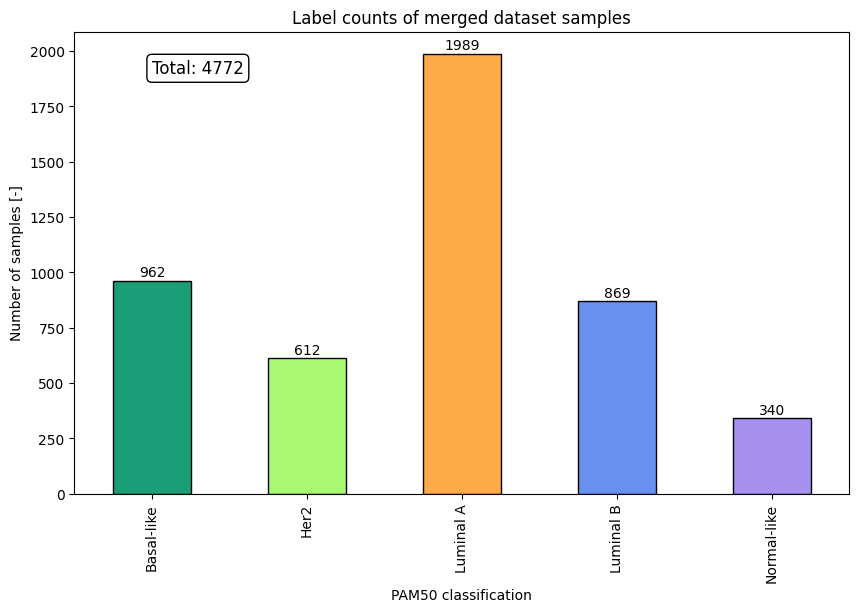

In [21]:
plot_label_counts(final_metadata_df, 1900)

## Preprocessing Part II

* Converting rownames to ENTREZ ID
* Conversion of genes to genesets with FunctionalSpectra()
* PCA
* t-SNE
* UMAP

### Conversion of rownames to ENTREZ, converting genes to functional spectra

In [26]:
meta_df = final_metadata_df 
meta_df["Platform"] = meta_df["Dataset"].map(d_ilmn)
meta_df.head()

Sample ID   Dataset      PAM50                 Platform
0  GSM1280615  GSE53031       Her2  Affymetrix HG 219 Array
1  GSM1280616  GSE53031  Luminal B  Affymetrix HG 219 Array
2  GSM1280617  GSE53031       Her2  Affymetrix HG 219 Array
3  GSM1280618  GSE53031  Luminal A  Affymetrix HG 219 Array
4  GSM1280619  GSE53031  Luminal B  Affymetrix HG 219 Array

In [27]:
meta_df = meta_df.drop_duplicates(subset="Sample ID")
meta_df.shape

(3514, 4)

In [28]:
meta_df.groupby("Platform")["PAM50"].count()

Platform
Affymetrix HG 219 Array       167
Affymetrix HG U133A Array     508
Affymetrix HG133plus2        1938
Agilent Array                 283
Illumina Array                300
RNA sequencing                 93
Rosetta/Merck HG2plus2        120
Name: PAM50, dtype: int64

In [29]:
# Illumina probe IDs for conversion to ENTREZ (HumanHT-12 v4 BeadChip, HumanHT-12 v3 Expression BeadChip)
# wget https://emea.support.illumina.com/content/dam/illumina-support/documents/downloads/productfiles/humanht-12/v3/humanht-12_v3_0_r3_11283641_a_txt.zip and in supplementary GEO website GSE60789
illumina_probes_V4 = pd.read_csv(f"{path}/GPL10558_HumanHT-12_V4_0_R1_15002873_B.txt.gz", compression="gzip", sep="\t", skiprows=8)
illumina_probes_V4 = edit_conversion_dataset(illumina_probes_V4,["ILMN_Gene", "Entrez_Gene_ID", "Probe_Id"], "Entrez_Gene_ID")

illumina_probes_V3 = pd.read_csv(f"{path}/humanht-12_v3_0_r3_11283641_a_txt.zip", compression="zip", sep="\t", skiprows=8)
illumina_probes_V3 = edit_conversion_dataset(illumina_probes_V3,["ILMN_Gene", "Entrez_Gene_ID", "Probe_Id"], "Entrez_Gene_ID")

In [30]:
# Affymetrix conversion to ENTREZ (Affymetrix Human Genome U133 Plus 2.0 Array)
ensembl_df = get_ensembl_mappings()
ensembl_df.head()

Affymetrix    Hugo  Entrez
4   1553551_s_at  MT-ND1  4535.0
8   1553551_s_at  MT-ND2  4536.0
14  1553538_s_at  MT-CO1  4512.0
15  1553570_x_at  MT-CO1  4512.0
16    1553569_at  MT-CO1  4512.0

In [31]:
# Agilent probe IDs for conversion to ENTREZ (Agilent-028004 SurePrint G3 Human GE 8x60K Microarray)
agilent_probes = pd.read_csv(f"{path}/GPL14550-9757.txt", skiprows=17, sep="\t")
agilent_probes = edit_conversion_dataset(agilent_probes, ["ID", "GENE", "GENE_SYMBOL"], "GENE")

In [32]:
## Afymetrix probe IDs for conversion to ENTREZ (Affymetrix Human Genome U219 Array)
aff_array = pd.read_csv(f"{path}/GPL13667-15572.txt", sep="\t", skiprows=43)
aff_array = edit_conversion_dataset(aff_array, ["ID", "Entrez Gene", "Gene Symbol"], "Entrez Gene")
aff_array = aff_array[aff_array["Entrez Gene"] != "---"]
aff_array = aff_array.drop_duplicates(subset="Entrez Gene", keep="last")
aff_array = aff_array[~aff_array["Entrez Gene"].str.contains("///")]
aff_array.shape

/tmp/ipykernel_10833/2065054642.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  aff_array = pd.read_csv(f"{path}/GPL13667-15572.txt", sep="\t", skiprows=43)


(19040, 3)

In [33]:
## TGI probe IDs for conversion to ENTREZ ### GSE56493 (Rosetta/Merck Human RSTA Custom Affymetrix 2.0 microarray)
tgi_probes = pd.read_csv(f"{path}/tgi.txt", sep="\t", skiprows=11)
tgi_probes = edit_conversion_dataset(tgi_probes, ["ID", "EntrezGeneID", "GeneSymbol"], "EntrezGeneID")

In [ ]:
%%script false --no-raise-error
count_df = pd.DataFrame()

dff = pd.DataFrame()
count = 0

final_brca_df = pd.DataFrame()
metadata_brca_df =  pd.DataFrame()

pipe = make_pipeline(FunctionalSpectra())

for f in os.listdir(f"{path}/BRCA/all_processed/NO_ENTREZ_CONVERSION/"):
  if f.endswith(".csv"):
    count += 1
    geo_name = f.split("_")[0]
    tdf = pd.read_csv(f"{path}/BRCA/all_processed/NO_ENTREZ_CONVERSION/{f}", index_col=0)
    print(geo_name)
    if geo_name in ["GSE78958", "GSE25066", "GSE21653", "GSE48390", "GSE20711", "GSE65194", "GSE45827"]: 
      dff = merge_counts(tdf, ensembl_df, "Affymetrix", "Entrez", "Hugo")
    elif geo_name == "GSE60789":
      dff = merge_counts(tdf, illumina_probes_V4, "Probe_Id", "Entrez_Gene_ID", "ILMN_Gene") #Illumina solved
    elif geo_name == "GSE59595":
      dff = merge_counts(tdf, illumina_probes_V3, "Probe_Id", "Entrez_Gene_ID", "ILMN_Gene") #Illumina solved
    elif geo_name == "GSE58215": # Agilent 	solved
      dff = merge_counts(tdf, agilent_probes, "ID", "GENE", "GENE_SYMBOL")
    #elif geo_name == "GSE115577":  # Entrez ID solved
    #  continue
    elif geo_name == "GSE135298": # Gene name solved
      dff = merge_counts(tdf, ensembl_df, "Hugo", "Entrez", "Affymetrix")
    elif geo_name == "GSE56493":
      dff = merge_counts(tdf, tgi_probes, "ID", "EntrezGeneID", "GeneSymbol")
    elif geo_name == "GSE53031":
      dff = merge_counts(tdf, aff_array, "ID", "Entrez Gene", "Gene Symbol")
    dff = dff[~dff.index.duplicated()]
    dff.index.name = "Entrez"
    dff.index = dff.index.astype(int)
    dff = dff.T
    #dff.to_csv(f"{path}/BRCA/all_processed/{geo_name}.csv.gz", compression="gzip")
    # Functional Spectra
    fs = pipe.fit(dff, _)
    final_brca_df = final_brca_df.append(fs.named_steps['deepcc'].getLastTransform())
    print(geo_name)
    print(f"file: {geo_name}, shape: {dff.shape}, shape FS {final_brca_df.shape}")
    fs.named_steps['deepcc'].getLastTransform().to_csv(f"{path}/BRCA/DeepCC_processed/{geo_name}_fs.csv.gz", compression="gzip")

In [35]:
%%script false --no-raise-error
small = ['X1_T1', 'X2_T2', 'X3_T3', 'X4_T4', 'X5_T5', 'X6_T6', 'X7_T7', 'X8_T8', 'X9_T9', 'X10_T10', 'X11_T11', 'X12_T12', 'X13_T13', 'X14_T14', 'X15_T15', 'X18_T18', 'X19_T19', 'X20_T20', 'X21_T21', 'X22_T22', 'X23_T23', 'X26_T26', 'X27_T27', 'X28_T28', 'X29_T29', 'X30_T30', 'X31_T31', 'X32_T32', 'X33_T33', 'X34_T34', 'X35_T35', 'X38_T38', 'X39_T39', 'X40_T40', 'X41_T41', 'X42_T42', 'X43_T43', 'X1_T44', 'X3_T46', 'X5_T48', 'X7_T50', 'X9_T52', 'X11_T54', 'X13_T56', 'X15_T58', 'X16_T59', 'X18_T61', 'X19_T62', 'X20_T63', 'X21_T64', 'X23_T66', 'X28_T71', 'X30_T73', 'X32_T75', 'X33_T76', 'X38_T81', 'X40_T83', 'X45_T88', 'X46_T89', 'X48_T91', 'X53_T96', 'X54_T97', 'X60_T103', 'X62_T105', 'X64_T107', 'X68_T111', 'X70_T113', 'X71_T114', 'X72_T115', 'X74_T117', 'X76_T119', 'X77_T120', 'X79_T122', 'X81_T124', 'X82_T125', 'X84_T127', 'X86_T129', 'X88_T131', 'X90_T133', 'X91_T134', 'X92_T135', 'X94_T137', 'X97_T138', 'X99_T140', 'X101_T142', 'X102_T143', 'X103_T144', 'X104_T145', 'X105_T146', 'X107_T148_2', 'X108_T149', 'X109_T150_2', 'X110_T151', 'X111_T152', 'X112_T153', 'X113_T154', 'X114_T155', 'X115_T156']
small2 = ['X3_M3', 'X7_M7', 'X9_M9', 'X11_M11', 'X13_M13', 'X15_M15', 'X17_M17', 'X19_M19', 'X21_M21', 'X23_M23', 'X25_M25', 'X27_M27', 'X29_M29', 'X31_M31', 'X33_M33', 'X35_M35', 'X39_M39', 'X41_M41', 'X43_M43', 'X45_M45', 'X47_M47', 'X1_M49', 'X3_M51', 'X5_M53', 'X7_M55', 'X9_M57', 'X11_M59', 'X17_M65', 'X19_M67', 'X21_M69', 'X23_M71', 'X25_M73', 'X27_M75', 'X29_M77', 'X31_M79', 'X33_M81', 'X35_M83', 'X37_M85', 'X39_M87', 'X41_M89', 'X42_M91', 'X44_M93', 'X1_M95', 'X3_M97', 'X5_M99', 'X7_M101', 'X9_M103', 'X11_M105', 'X13_M107', 'X15_M109', 'X17_M111', 'X23_M117', 'X25_M119', 'X27_M121', 'X29_M123', 'X33_M127', 'X35_M129', 'X37_M131', 'X39_M133', 'X41_M135', 'X43_M137', 'X45_M139', 'X47_M141', 'X49_M143', 'X51_M145', 'X53_M147', 'X55_M149', 'X57_M151', 'X59_M153', 'X63_M157', 'X65_M159', 'X67_M161', 'X69_M163', 'X71_M165', 'X73_M167', 'X77_M171', 'X79_M173', 'X81_M175', 'X83_M177', 'X85_M179', 'X87_M181', 'X89_M183', 'X91_M185', 'X93_M187', 'X1_M189', 'X25_M191', 'X49_M193', 'X73_M195', 'X2_M197', 'X26_M199', 'X50_M201', 'X74_M203', 'X3_M205', 'X27_M207', 'X51_M209', 'X75_M211', 'X4_M213', 'X28_M215', 'X52_M217', 'X76_M219', 'X5_M221', 'X29_M223', 'X53_M225', 'X77_M227', 'X6_M229', 'X30_M231', 'X54_M233', 'X78_M235', 'X7_M237', 'X31_M239', 'X55_M241', 'X79_M243', 'X8_M245', 'X56_M249', 'X80_M251', 'X9_M253', 'X33_M255', 'X57_M257', 'X81_M259', 'X10_M261', 'X34_M263', 'X58_M265', 'X82_M267', 'X11_M269', 'X35_M271', 'X59_M273', 'X83_M275', 'X12_M277', 'X36_M279', 'X60_M281', 'X3_M283', 'X5_M285', 'X7_M287', 'X9_M289', 'X98_M291', 'X12_M293_.HTA.2_0', 'X146_M295', 'X170_M297', 'X99_M299', 'X123_M301', 'X147_M303', 'X171_M305', 'X6_M309', 'X2_M311', 'X9_M313', 'X13_M317', 'X17_M321', 'X19_M323', 'X126_M325', 'X22_M327', 'X24_M329', 'X26_M331', 'X28_M333', 'X30_M335', 'X32_M337', 'X34_M339', 'X36_M341', 'X38_M343', 'X40_M345', 'X42_M347', 'X43_M349', 'X45_M351', 'X47_M353', 'X49_M355', 'X53_M359', 'X55_M361', 'X59_M365', 'X60_M367', 'X62_M369', 'X64_M371', 'X65_M373', 'X67_M375', 'X193_M377', 'X195_M379', 'X197_M381', 'X199_M383', 'X201_M385', 'X203_M387', 'X207_M391', 'X70_M393', 'X211_M395', 'X71_M397']
small.extend(small2)


pipe = make_pipeline(FunctionalSpectra())
GSE115577_df = pd.read_csv(f"{path}/BRCA/all_processed/NO_ENTREZ_CONVERSION/GSE115577_counts.csv", index_col=0)
GSE115577_df.index = GSE115577_df.index.astype(int)
GSE115577_df_small = GSE115577_df[small]
GSE115577_df_small = GSE115577_df_small.dropna()
GSE115577_df_small.shape
GSE115577_df_small =  GSE115577_df_small.T
fs = pipe.fit(GSE115577_df_small, _)
final_GSE115577_df = fs.named_steps['functionalspectra'].getLastTransform()
GSE115577_df_big = GSE115577_df.drop(small, axis=1)
GSE115577_df_big.shape
GSE115577_df_big.index = GSE115577_df_big.index.astype(int)
GSE115577_df_big =  GSE115577_df_big.T
fs = pipe.fit(GSE115577_df_big, _)
GSE115577_df_big_final = fs.named_steps['functionalspectra'].getLastTransform()

final_brca_df = final_brca_df.append(final_GSE115577_df).append(GSE115577_df_big_final)

Called FunctionalSpectra


### t-SNE

In [ ]:
# loading data
final_brca_df = pd.read_csv(f"{path}/BRCA/DeepCC_processed/GEO_merged_deepcc.csv.gz", compression="gzip",index_col=0)
meta_df = pd.read_csv(f"{path}/BRCA/DeepCC_processed/GEO_metadata_merged_deepcc.csv.gz", compression="gzip",index_col=0)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=50)
projections = tsne.fit_transform(final_brca_df.T)

/home/simonova/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/simonova/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
fig = px.scatter(
    projections, x=0, y=1,
    color=meta_df["PAM50"], width=800, height=700,
)
fig.show()

In [ ]:
fig = px.scatter(
    projections, x=0, y=1,
    color=meta_df["Platform"], width=1100, height=700,
)
fig.show()

### PCA

In [ ]:
comp_brca, labels_brca = scale_pca(final_brca_df.T)

In [ ]:
fig = px.scatter_matrix(
    comp_brca,
    labels=labels_brca,
    dimensions=range(2),
    color = meta_df["PAM50"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035

fig.update_traces(diagonal_visible=False)
fig.show()

/home/simonova/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  dims = [
/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



In [ ]:
fig = px.scatter_matrix(
    comp_brca,
    labels=labels_brca,
    dimensions=range(2),
    color = meta_df["Dataset"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035

fig.update_traces(diagonal_visible=False)
fig.show()

/home/simonova/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [ ]:
fig = px.scatter_matrix(
    comp_brca,
    labels=labels_brca,
    dimensions=range(2),
    color = meta_df["Platform"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035

fig.update_traces(diagonal_visible=False)
fig.show()

/home/simonova/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



### UMAP

In [ ]:
from umap import UMAP

umap_2d = UMAP(n_components=2, init='random', random_state=0)
#umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(final_brca_df.T)
#proj_3d = umap_3d.fit_transform(final_brca_df)

#fig_3d = px.scatter_3d(
#    proj_3d, x=0, y=1, z=2,
#    color=meta_df["Label"], labels={'color': 'Label'}
#)
#fig_3d.update_traces(marker_size=5)

In [ ]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=meta_df["PAM50"], labels={'color': 'Label'}
)
fig_2d.show()

In [ ]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=meta_df["Platform"], labels={'color': 'Label'}
)
fig_2d.show()

## Saving preprocessed GEO breast cancer data

In [ ]:
final_brca_df.to_csv(f"{path}/BRCA/DeepCC_processed/GEO_merged_deepcc.csv.gz", compression="gzip")
meta_df.to_csv(f"{path}/BRCA/DeepCC_processed/GEO_metadata_merged_deepcc.csv.gz", compression="gzip")